# Dataset

The dataset contains the sales price of hundreds of houses in Ames, Iows and 79 distinct features to describe each house. 

# Objective

Our objective is to predict the sale price of residential homes using the features given in the dataset. I will perform data cleaning, preporcessing and regression algorithms to achieve the lowest root mean square error (RMSE) for each prediction. 

In [803]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import matplotlib.pyplot as plt

##### Let's read and open the dataset

In [403]:
df=pd.read_csv('data/train.csv')

Here's a glimpse of the dataset

In [404]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Exploring Dataset

In [405]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Let's have a look at correlation between the target variable "Sales Price" and all the numerical features. We will draw a heat map where the darker color means higher correlation with the target variable. 

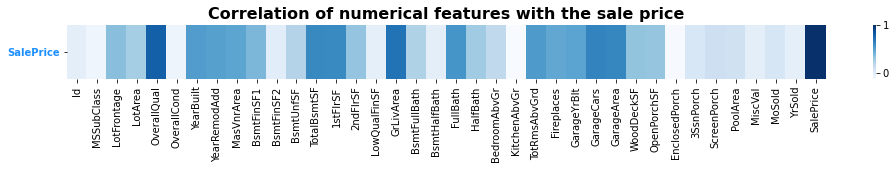

In [407]:
df_num = df.select_dtypes(exclude = 'object')
df_num_corr = df_num.corr()
f,ax=plt.subplots(figsize=(17,1))
sns.heatmap(df_num_corr.sort_values(by=['SalePrice'], ascending=False).head(1),
            cmap='Blues');
plt.title('Correlation of numerical features with the sale price', weight = 'bold', fontsize = 16)
plt.yticks(weight='bold', color='dodgerblue', rotation=0)
plt.show()

We can show the correlation in a form of a table as below

In [408]:
num_corr = df_num_corr['SalePrice'].sort_values(ascending=False).head(20).to_frame()
num_corr.style.background_gradient()

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


The table clearly shows which features affect the target Sales Price the most. 

## Data Cleaning

Here, we will take care of the missing values. Let's have a look at the features with missing values in a descending order and then we will decide what to do with them.


In [411]:
missing_total = df.isnull().sum().sort_values(ascending = False)
missing_data_percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending = False)
missing_data = pd.concat([missing_total, missing_data_percent], axis = 1, keys = ["Total Missing", "Percentage Missing"])
missing_data.head(20)

,Total Missing,Percentage Missing
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageCond,81,5.547945
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


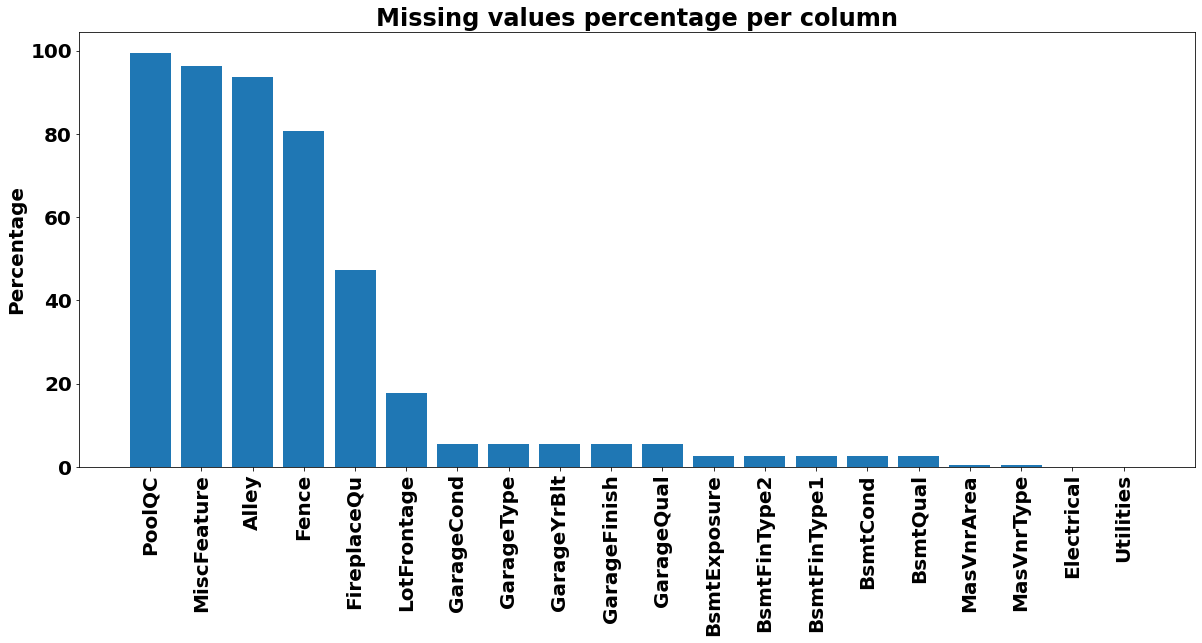

In [412]:
missing_percent_20 = missing_data_percent.head(20)
plt.figure(figsize = (20,8))
plt.bar(*zip(*missing_percent_20.items()))
plt.xticks(fontsize = 20, weight = 'bold', rotation = 90)
plt.yticks(fontsize = 20, weight = 'bold')
plt.title("Missing values percentage per column", fontsize = 24, weight = 'bold')
plt.ylabel('Percentage', fontsize = 20, weight = 'bold')
plt.show()

We will drop the features with more than 40% missing values as these features are uninformative for prediction of target variable. 

In [413]:
df = df.drop((missing_data[missing_data['Percentage Missing']>40]).index,1)

In [414]:
dropped = (missing_data[missing_data['Percentage Missing']>40]).index
print(f"We dropped {len(dropped)} features in the set")

We dropped 5 features in the set


Let's make sure those features are dropped

In [415]:
missing_total = df.isnull().sum().sort_values(ascending = False)
missing_data_percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending = False)
missing_data = pd.concat([missing_total, missing_data_percent], axis = 1, keys = ["Total Missing", "Percentage Missing"])
missing_data.head(20)

,Total Missing,Percentage Missing
LotFrontage,259,17.739726
GarageFinish,81,5.547945
GarageType,81,5.547945
GarageCond,81,5.547945
GarageQual,81,5.547945
GarageYrBlt,81,5.547945
BsmtExposure,38,2.602740
BsmtFinType2,38,2.602740
BsmtFinType1,37,2.534247
BsmtCond,37,2.534247


In [416]:
all_NA = df[missing_data[missing_data['Total Missing']>0].index]

Now we need to take care of the remaining features with null values. We will divide the features into two categories:
--Numerical Features
--Categorical Features

In [417]:
null_num = all_NA.select_dtypes(exclude = 'object')
null_cat = all_NA.select_dtypes(include = 'object')

In [418]:
print(f"We have {null_num.shape[1]} null numerical features")
print(f"We have {null_cat.shape[1]} null categorical features")

We have 3 null numerical features
We have 11 null categorical features


In [419]:
null_num.head()

,LotFrontage,GarageYrBlt,MasVnrArea
0,65.0,2003.0,196.0
1,80.0,1976.0,0.0
2,68.0,2001.0,162.0
3,60.0,1998.0,0.0
4,84.0,2000.0,350.0


In [420]:
#Lot Frontage has ~18% missing values so we will fill them with median value
df['LotFrontage'] = df.LotFrontage.fillna(df.LotFrontage.median())

#We will fill the GarageYrBlt with the median value too (1980)
df['GarageYrBlt'] = df.GarageYrBlt.fillna(1980)

#Na for ManVnrArea means no veneer so we will fill Nan values with 0
df['MasVnrArea'] = df.MasVnrArea.fillna(0)

In [421]:
null_cat.head()

,GarageFinish,GarageType,GarageCond,GarageQual,BsmtExposure,BsmtFinType2,BsmtFinType1,BsmtCond,BsmtQual,MasVnrType,Electrical
0,RFn,Attchd,TA,TA,No,Unf,GLQ,TA,Gd,BrkFace,SBrkr
1,RFn,Attchd,TA,TA,Gd,Unf,ALQ,TA,Gd,None,SBrkr
2,RFn,Attchd,TA,TA,Mn,Unf,GLQ,TA,Gd,BrkFace,SBrkr
3,Unf,Detchd,TA,TA,No,Unf,ALQ,Gd,TA,None,SBrkr
4,RFn,Attchd,TA,TA,Av,Unf,GLQ,TA,Gd,BrkFace,SBrkr


There are total 11 categorical features with missing values and 9 of those are either basement or garage related, which implies that those houses lack either garages or basements. So we will replace the missing values with None. Missing MasVnrType implied no veneer so we replace the missing values with None. 

In [422]:
Null_cols = null_cat.columns
for col in Null_cols:
    df[col] = df[col].fillna("None")

We will fill the "Electrical" missing values with forward filling method

In [423]:
df['Electrical'] = df['Electrical'].fillna('ffill')

In [424]:
df.isnull().sum().sum()

0

Finally, we end up with a clean dataset with no Null or missing values. 

## Encoding categorical features

### One hot encoding

In [545]:
df_enc = pd.get_dummies(df)

In [546]:
print(f" Shape of original dataset {df.shape}")
print(f" Shape of One Hot Encoded dataset {df_enc.shape}")

 Shape of original dataset (1460, 76)
 Shape of One Hot Encoded dataset (1460, 282)


## Outliers Detection

We will use scatter plots to detect the outliers for numerical features

Let's start with Ground Living Area

Text(0.5, 0, 'Ground Living Area')

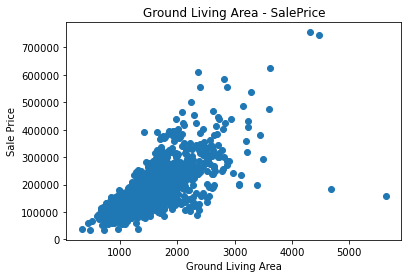

In [547]:
plt.scatter(x=df['GrLivArea'], y = df['SalePrice'])
plt.title('Ground Living Area - SalePrice')
plt.ylabel('Sale Price')
plt.xlabel('Ground Living Area')

We can see that the two values on the extreme right side do not follow the pattern and are therefore the outliers. 

Now we will draw outliers for some features usng subplots

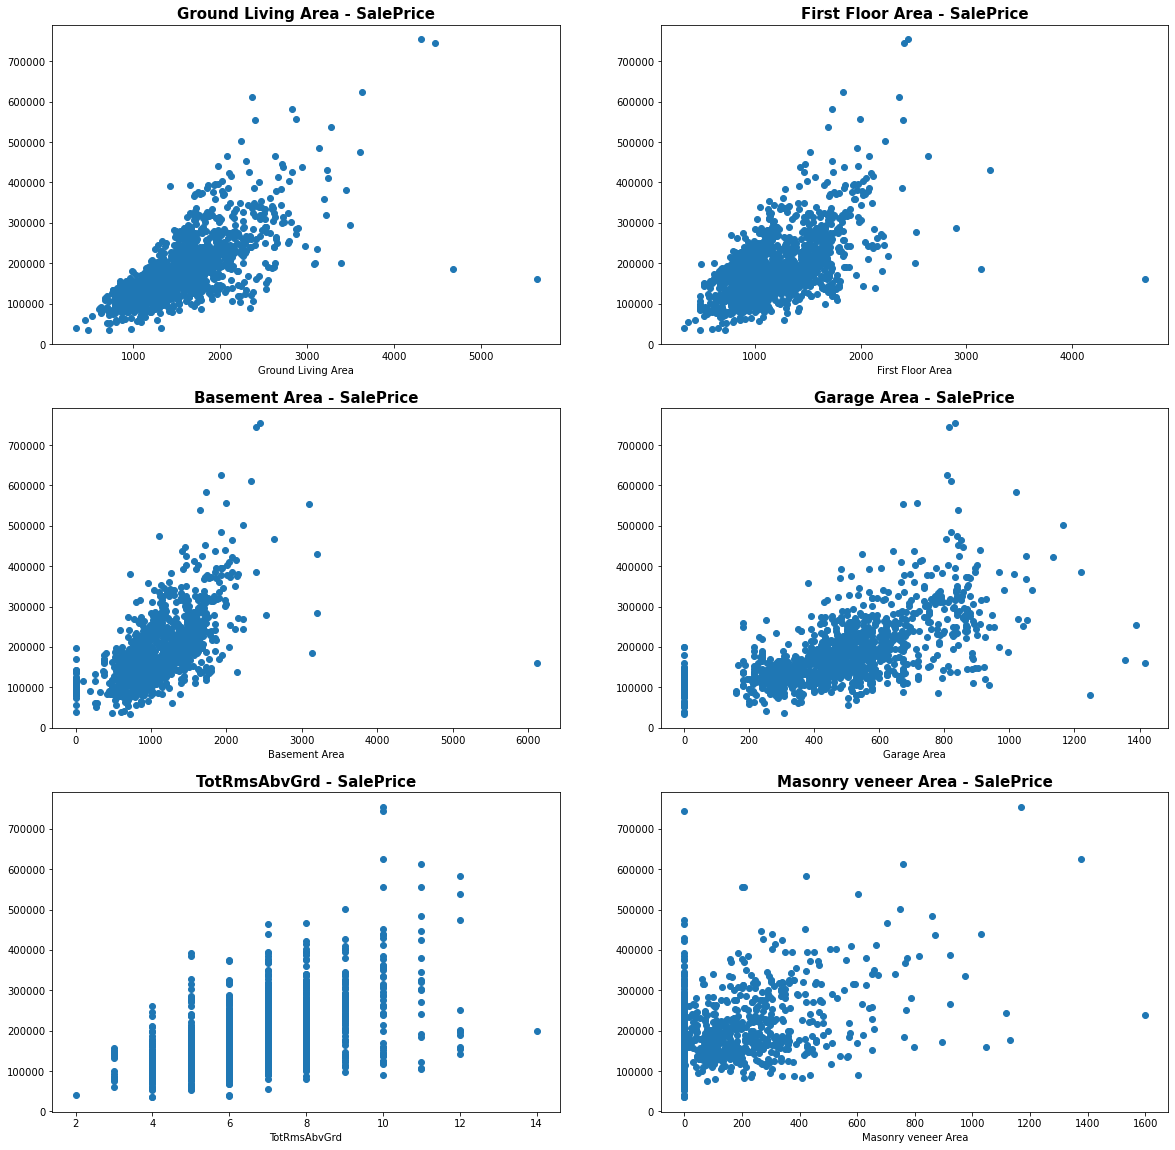

In [548]:
plt.figure(figsize = (20,20))
ax1 = plt.subplot2grid((3,2),(0,0))
plt.scatter(x=df['GrLivArea'], y = df['SalePrice'])
plt.title('Ground Living Area - SalePrice', weight = 'bold', fontsize = 15)
plt.xlabel('Ground Living Area')

ax1 = plt.subplot2grid((3,2),(0,1))
plt.scatter(x=df['1stFlrSF'], y = df['SalePrice'])
plt.title('First Floor Area - SalePrice', weight = 'bold', fontsize = 15)
plt.xlabel('First Floor Area')

ax1 = plt.subplot2grid((3,2),(1,0))
plt.scatter(x=df['TotalBsmtSF'], y = df['SalePrice'])
plt.title('Basement Area - SalePrice', weight = 'bold', fontsize = 15)
plt.xlabel('Basement Area')

ax1 = plt.subplot2grid((3,2),(1,1))
plt.scatter(x=df['GarageArea'], y = df['SalePrice'])
plt.title('Garage Area - SalePrice', weight = 'bold', fontsize = 15)
plt.xlabel('Garage Area')

ax1 = plt.subplot2grid((3,2),(2,0))
plt.scatter(x=df['TotRmsAbvGrd'], y = df['SalePrice'])
plt.title('TotRmsAbvGrd - SalePrice', weight = 'bold', fontsize = 15)
plt.xlabel('TotRmsAbvGrd')

ax1 = plt.subplot2grid((3,2),(2,1))
plt.scatter(x=df['MasVnrArea'], y = df['SalePrice'])
plt.title('Masonry veneer Area - SalePrice', weight = 'bold', fontsize = 15)
plt.xlabel('Masonry veneer Area')

plt.show()

#### Outliers Localization

We will sort the columns containing the outliers and use head() function to identify the ids of outliers and then remove them

In [549]:
df['GrLivArea'].sort_values(ascending = False).head(2)

1298    5642
523     4676
Name: GrLivArea, dtype: int64

In [550]:
df['1stFlrSF'].sort_values(ascending = False).head(1)

1298    4692
Name: 1stFlrSF, dtype: int64

In [551]:
df['TotalBsmtSF'].sort_values(ascending = False).head(1)

1298    6110
Name: TotalBsmtSF, dtype: int64

In [552]:
df['GarageArea'].sort_values(ascending = False).head(4)

1298    1418
581     1390
1190    1356
1061    1248
Name: GarageArea, dtype: int64

In [553]:
df['MasVnrArea'].sort_values(ascending = False).head(1)

297    1600.0
Name: MasVnrArea, dtype: float64

#### Outliers Removal

We have collected the indices of all the outliers for the above features. We will now remove these points from the dataset. 

In [554]:
outliers_pos = [1298, 523, 581, 1190, 1061, 297]
df_enc.drop(df_enc.index[outliers_pos], inplace=True)

Since, we have removed six rows fromt the dataset, we should now have 1454 rows

In [555]:
print(f"Total remaining rows: {df_enc.shape[0]}")

Total remaining rows: 1454


Let's plot a scatter plot of Garage Area to confirm that outlier have been successfully removed

Text(0.5, 0, 'Garage Area')

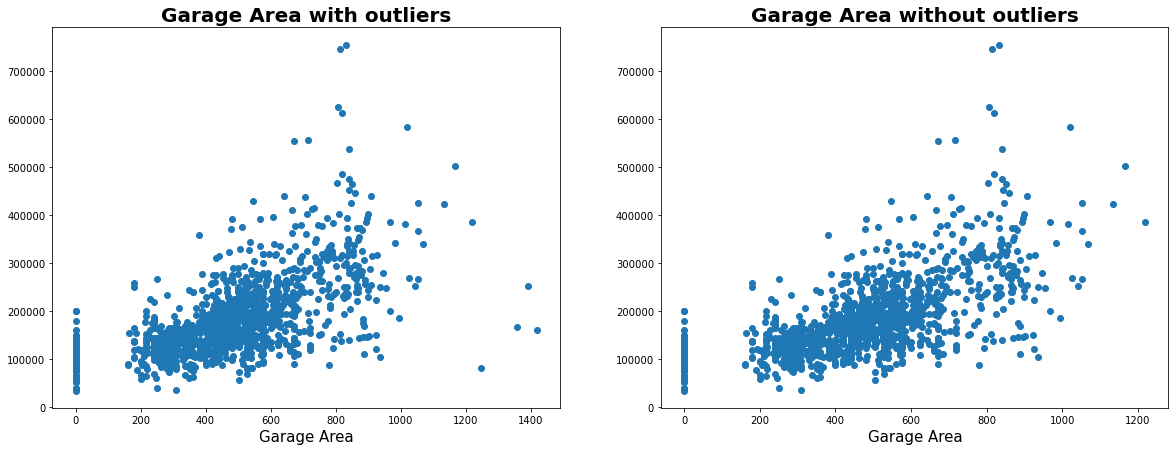

In [556]:
plt.figure(figsize = (20,7))

ax1 = plt.subplot2grid((1,2),(0,0))
plt.scatter(x=df['GarageArea'], y = df['SalePrice'])
plt.title('Garage Area with outliers', fontsize = 20, weight = 'bold')
plt.xlabel('Garage Area', fontsize = 15)

ax1 = plt.subplot2grid((1,2),(0,1))
plt.scatter(x=df_enc['GarageArea'], y = df_enc['SalePrice'])
plt.title('Garage Area without outliers', fontsize = 20, weight = 'bold')
plt.xlabel('Garage Area', fontsize = 15)

We can see that outliers have been removed. 

## Data Preprocessing

#### Skewed Target Variable

I will take the log transform of the target variable to eradicate skewness and have a symmetrical dirtrubution as it leads of better prediction model.

In [557]:
target = df_enc['SalePrice']
target= np.log1p(target)

In [558]:
print(f"Skewness before log transform: {df_enc['SalePrice'].skew()}")
print(f"Kurtosis before log transform: {df_enc['SalePrice'].kurt()}")

Skewness before log transform: 1.8855157408676113
Kurtosis before log transform: 6.534598282611192


In [657]:
print(f"Skewness after log transform: {target.skew()}")
print(f"Kurtosis after log transform: {target.kurt()}")

Skewness after log transform: 0.12516257969329844
Kurtosis after log transform: 0.8128307268373107


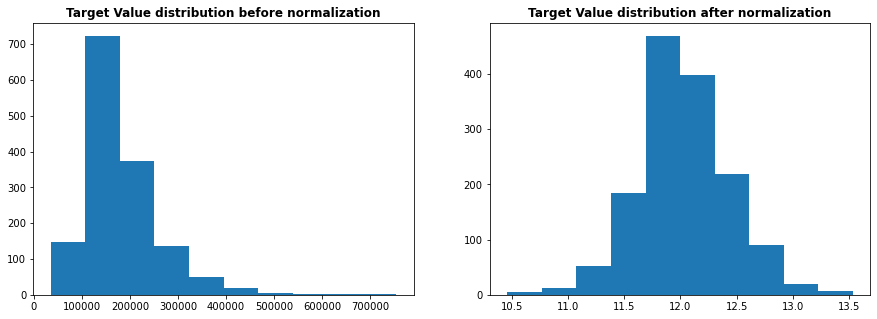

In [656]:
plt.figure(figsize = (15,5))
ax1 = plt.subplot2grid((1,2),(0,0))
plt.hist(df.SalePrice)
plt.title("Target Value distribution before normalization", weight = 'bold')

ax1 = plt.subplot2grid((1,2),(0,1))
plt.hist(target)
plt.title("Target Value distribution after normalization", weight = 'bold')
plt.show()

#### Defining features and target variables

In [560]:
y = np.array(target)

In [561]:
df_enc.drop(['SalePrice'], axis =1, inplace = True)
df_enc.drop(['Id'], axis =1, inplace = True)

In [562]:
X = df_enc

## Machine Learning

Splitting the Dataset into train (80%) and test (20%) sets

In [563]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .2, random_state=0)

In [564]:
y_train.shape

(1163,)

In [565]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Models

We will start with linear Regression models with regularization

Metric: Root Mean Square Error(RMSE)

In [566]:
def score(y_preds):
    RMSE = str(np.sqrt(metrics.mean_squared_error(y_test, y_preds)))
    return RMSE

In [567]:
#Defining the RMSE function for cross validation
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

#### Ridge Regression

Ridge regression implements the following function
||y - Xw||^2_2 + alpha * ||w||^2_2

where alpha is the regularization parameter. Higher the alpha, the less prone the model will be to overfitting. However, higher alpha might cause our model to have higher bias, therefore will will tune this hyperparameter.

Tuning the hypermeter alpha for the lowest RMSE score.

In [702]:
alphas = [0.03, 0.1, 0.3, 1, 3, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

Let's plot the RMSE for the range of alpha values

Text(0, 0.5, 'RMSE')

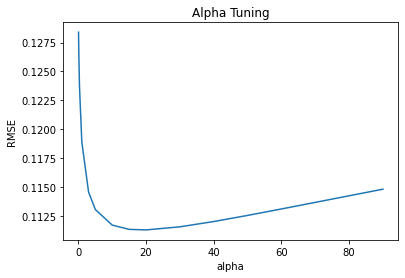

In [703]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Alpha Tuning")
plt.xlabel("alpha")
plt.ylabel("RMSE")

Lowest RMSE is observed at alpha = 20 so let's predict output for X_test with alpha = 20

In [615]:
ridge_mod=Ridge(alpha=20)
ridge_mod.fit(X_train,y_train)
y_pred_train_ridge=ridge_mod.predict(X_train)
y_pred_test_ridge=ridge_mod.predict(X_test)

In [616]:
print(f'Root Mean Square Error train =  {str(math.sqrt(metrics.mean_squared_error(y_train, y_pred_train_ridge)))}')
print(f'Root Mean Square Error test =  {score(y_pred_test_ridge)}') 

Root Mean Square Error train =  0.08904796404662939
Root Mean Square Error test =  0.12088834359658635


Let's restore the y_test and y_preds by taking exponential 

In [618]:
y_preds_res_rg = np.expm1(y_pred_test_ridge)
y_preds_res_rg = np.rint(y_preds_res_rg).astype(int)
y_test_res = np.expm1(y_test)

Let's define a function to show a dataframe comparing the actual and predicted values

In [619]:
def comp_pred(y_preds):
    preds_data = {'Actual':y_test_res.flatten(), 'Predicted':y_preds.flatten()}
    df_pred = pd.DataFrame(preds_data)
    df_pred_20 = df_pred.head(20)
    return df_pred_20

In [621]:
df_pred = comp_pred(y_preds_res_rg)
df_pred

,Actual,Predicted
0,160000.0,124622
1,147500.0,150881
2,225000.0,228260
3,297000.0,299312
4,274725.0,254430
5,320000.0,305954
6,187500.0,181258
7,239000.0,251340
8,173500.0,178082
9,186700.0,204473


Let's plot the comparison

In [622]:
def plot_preds(df_pred):
    df_pred.plot(kind='bar',figsize=(10,8))
    plt.title("Actual and Predicted Sales Price", fontsize = 15, weight = 'bold')
    plt.ylabel("Sales Price", fontsize = 15)
    plt.show()

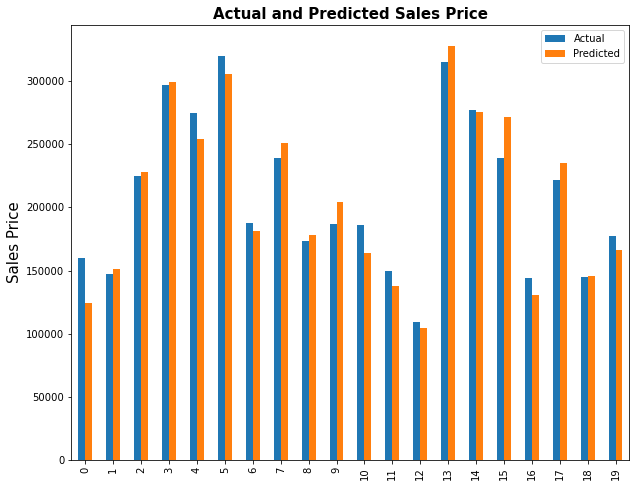

In [623]:
plot_preds(df_pred)

#### Lasso Regression
    The optimization objective for Lasso is:
    (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1

As we did before, let's tune the hyperparameter alpha

In [ ]:
alphas = [0.0001, 0.0003, 0.0009, 0.001, 0.003, 0.009, 0.01, 0.03, 0.09, 0.1, 1, 3, 9, 30, 90]
cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() for alpha in alphas]

In [596]:
cv_lasso

0.0001     0.117672
0.0003     0.112088
0.0009     0.109891
0.0010     0.110384
0.0030     0.119341
0.0090     0.129603
0.0100     0.130662
0.0300     0.156397
0.0900     0.220814
0.1000     0.232822
1.0000     0.393734
3.0000     0.396593
9.0000     0.397351
30.0000    0.397351
90.0000    0.397351
dtype: float64

The best value of Alpha: 0.0009 

In [638]:
lasso_mod=Lasso(alpha=0.0009)
lasso_mod.fit(X_train,y_train)
y_pred_train_lasso=lasso_mod.predict(X_train)
y_pred_test_lasso=lasso_mod.predict(X_test)

In [644]:
print(f'Root Mean Square Error train =  {str(math.sqrt(metrics.mean_squared_error(y_train, y_pred_train_lasso)))}')
print(f'Root Mean Square Error test =  {score(y_pred_test_lasso)}') 

Root Mean Square Error train =  0.09988629712953333
Root Mean Square Error test =  0.1208198435745864


In [645]:
y_preds_res_ls = np.expm1(y_pred_test_lasso)
y_preds_res_ls = np.rint(y_preds_res_ls).astype(int)

Actual and Predicted values using Lasso Regression for first 20 test examples

In [646]:
df_pred_lasso = comp_pred(y_preds_res_ls)
df_pred_lasso

,Actual,Predicted
0,160000.0,129105
1,147500.0,151814
2,225000.0,227040
3,297000.0,299467
4,274725.0,254259
5,320000.0,306960
6,187500.0,186694
7,239000.0,253127
8,173500.0,174838
9,186700.0,210651


Let's plot the comparison for Lasso Regression

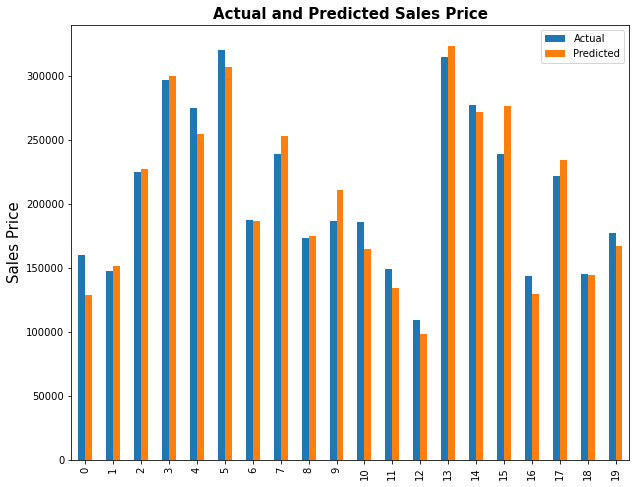

In [647]:
plot_preds(df_pred_lasso)

#### Random Forest Regressor

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [716]:
rf_model = RandomForestRegressor(n_estimators = 500, random_state = 0)
rf_model.fit(X_train, y_train)
y_pred_train_rf=rf_model.predict(X_train)
y_pred_test_rf=rf_model.predict(X_test)

In [717]:
print(f'Root Mean Square Error train =  {str(math.sqrt(metrics.mean_squared_error(y_train, y_pred_train_rf)))}')
print(f'Root Mean Square Error test =  {score(y_pred_test_rf)}') 

Root Mean Square Error train =  0.049725421871644554
Root Mean Square Error test =  0.14530837414214598


We can see that model has overfit the training data. I manually played with number of parameters such as n_estimators, max_samples, num_features etc but RMSE for test test did not get lower. My observation is that we need a larger dataset to tackle overfitting here. 

In [696]:
y_preds_res_rf = np.expm1(y_pred_test_rf)
y_preds_res_rf = np.rint(y_preds_res_rf).astype(int)

Actual and Predicted values using Random Forrest Regressor for first 20 test examples

In [697]:
df_pred_rf = comp_pred(y_preds_res_rf)
df_pred_rf

,Actual,Predicted
0,160000.0,142850
1,147500.0,149289
2,225000.0,228618
3,297000.0,314321
4,274725.0,232598
5,320000.0,334398
6,187500.0,198573
7,239000.0,249505
8,173500.0,178159
9,186700.0,178504


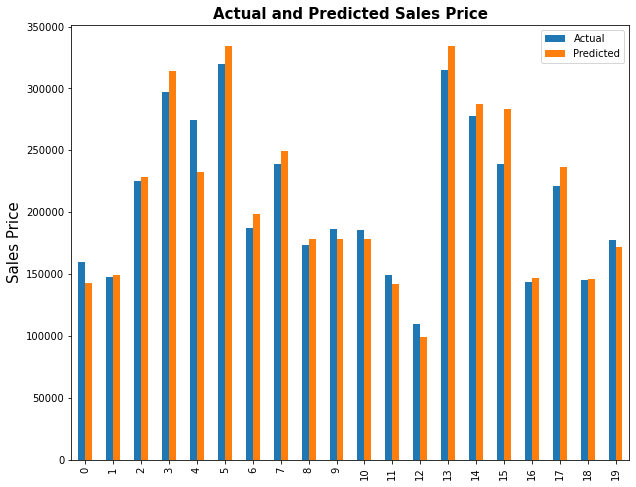

In [698]:
plot_preds(df_pred_rf)

#### Gradient Boosting Regressor

GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function.

In [818]:
gb_model = GradientBoostingRegressor(loss = 'huber', max_depth = 3, n_estimators = 400, max_features = 'sqrt',random_state = 0)
gb_model.fit(X_train, y_train)
y_pred_train_gb=gb_model.predict(X_train)
y_pred_test_gb=gb_model.predict(X_test)

In [819]:
print(f'Root Mean Square Error train =  {str(math.sqrt(metrics.mean_squared_error(y_train, y_pred_train_gb)))}')
print(f'Root Mean Square Error test =  {score(y_pred_test_gb)}') 

Root Mean Square Error train =  0.05730001957388684
Root Mean Square Error test =  0.1262748912999154


We see improved performance over Random Forrest Regressor and model has overfit the training data. I manually played with number of parameters such as n_estimators, learning rate, loss fun etc but RMSE for test test did not get lower than 0.12. My observation is that we need a larger dataset to tackle overfitting here.

In [795]:
y_preds_res_gb = np.expm1(y_pred_test_gb)
y_preds_res_gb = np.rint(y_preds_res_gb).astype(int)

Actual and Predicted values using Gradient Boosting Regressor for first 20 test examples

In [796]:
df_pred_gb = comp_pred(y_preds_res_gb)
df_pred_gb

,Actual,Predicted
0,160000.0,115336
1,147500.0,153222
2,225000.0,227964
3,297000.0,320734
4,274725.0,253439
5,320000.0,328649
6,187500.0,204442
7,239000.0,253309
8,173500.0,174466
9,186700.0,176607


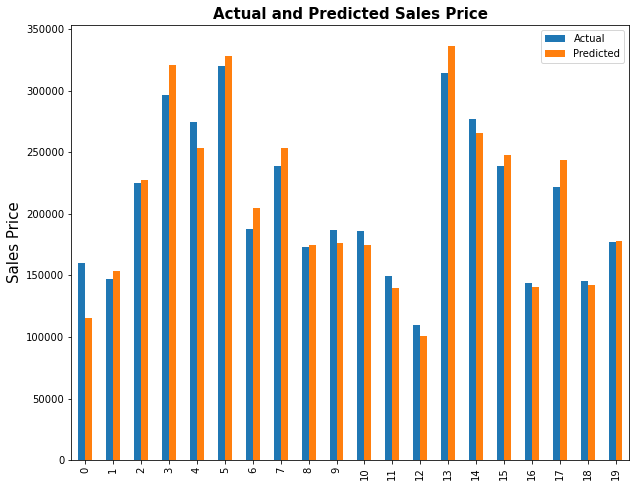

In [797]:
plot_preds(df_pred_gb)

#### XGBRegressor

In [860]:
xg_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.01,
                max_depth = 3, alpha = 15, n_estimators = 8000, reg_alpha=0.0001, reg_lambda=0.2)
xg_model.fit(X_train, y_train)
y_pred_train_xg=xg_model.predict(X_train)
y_pred_test_xg=xg_model.predict(X_test)

In [861]:
print(f'Root Mean Square Error train =  {str(math.sqrt(metrics.mean_squared_error(y_train, y_pred_train_xg)))}')
print(f'Root Mean Square Error test =  {score(y_pred_test_xg)}') 

Root Mean Square Error train =  0.025777323638681675
Root Mean Square Error test =  0.1257817197836104


We see improved performance over basic Gradient Boosting but model has overfit the training data. I manually tuned the hyper parameters but further tuning can be performed to improve the performance. However, gathering a larger dataset will significantly improve the model performance.

In [870]:
y_preds_res_xg = np.expm1(y_pred_test_xg)
y_preds_res_xg = np.rint(y_preds_res_xg).astype(int)

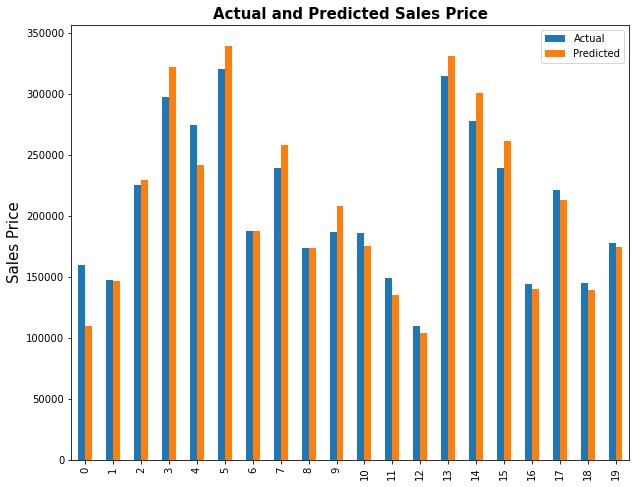

In [872]:
df_pred_xg = comp_pred(y_preds_res_xg)
plot_preds(df_pred_xg)